In [19]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_ct_attribution_STARmap_PLUS import *
from datasets.data_manager_STARmap_PLUS import AD_Mouse

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [20]:
%run ./args/args_STARmap_PLUS.py
args = args

### Load dataset

In [21]:
# create the dataloaders
dataset = AD_Mouse(AD_adata_path=args.AD_adata_path, Wild_type_adata_path=args.Wild_type_adata_path, n_top_genes=args.n_top_genes)
_, testloader, valloader = ad_mouse_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 124464 edges, 10372 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 115608 edges, 9634 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 96408 edges, 8034 cells.
12.0000 neighbors per cell on average.
=> AD Mouse loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  10372 spots, 894.0 positive tao, 291.0 positive plaque 
  test     |   9634 spots, 620.0 positive tao, 195.0 positive plaque 
  ------------------------------


### Load model

In [22]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.target_length
model = NicheTrans_ct(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('/home/wzk/ST_code/NicheTrans/0_NicheTrans_upload_v3/Models/NicheTrans*_STARmap_PLUS.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans_ct(
    (encoder_rna): NetBlock(
      (noise_dropout): Dropout(p=0.5, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=1719, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.25, inplace=False)
      )
    )
    (projection_rna): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features

# Inference 

In [23]:
inputs_list, outputs_list = [], []

with torch.no_grad():
    for _, (rna, protein, cell, rna_neighbor, cell_neighbor, _) in enumerate(testloader):

        rna, protein, cell, rna_neighbor, cell_neighbor = rna.cuda(), protein.cuda(), cell.cuda(), rna_neighbor.cuda(), cell_neighbor.cuda()
        cell_inf = torch.cat([cell[:, None, :], cell_neighbor], dim=1)
        omics = torch.cat([rna[:, None, :], rna_neighbor], dim=1)
        temp_input = torch.cat([omics, cell_inf], dim=2)

        outputs = model(temp_input)
        outputs = torch.sigmoid(outputs)
        
        ###########
        outputs = outputs[:, 0] > 0.5

        inputs_list.append(temp_input[outputs])
        outputs_list.append(outputs.cpu())

inputs_list = torch.cat(inputs_list, dim=0)
outputs_list = torch.cat(outputs_list, dim=0).numpy()

In [24]:
# do the gradient calculation
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

baseline = torch.zeros_like(inputs_list).cuda()

# Compute attributions
attributions = ig.attribute(inputs_list, baseline, target=0) 
attributions = attributions.detach().cpu().numpy()

attributions = np.abs(attributions)

In [ ]:
adata = sc.read_h5ad('/home/wzk/ST_code/NicheTrans/2024_NicheTrans_upload_data/2023_nn_AD_mouse/AD_model_adata_protein/13months-disease-replicate_2_random.h5ad')
adata.obs['pred'] = outputs_list

# C1qa  Cst7  Cst3  Tpt1
# Zhx1  Xbp1  Nrgn  Trf
# change the name of genes for different visualization
target = 'Cst7'

abeta_positive_index = adata.obs.index[outputs_list]
selected_attributions = attributions[:, 1:, : -13][:, :, (dataset.source_panel == target).squeeze()]

(9634, 2766)


In [29]:
adata = adata[:, dataset.rna_mask]
adata.var_names = dataset.source_panel

In [30]:
import matplotlib.cm as cm

cmap = cm.get_cmap('Reds')
max_ = attributions[:, 1:, : -13].max()
selected_attributions_ = selected_attributions / attributions[:, 1:, : -13].max()
color = cmap(selected_attributions_)

In [31]:
import matplotlib.patches as patches

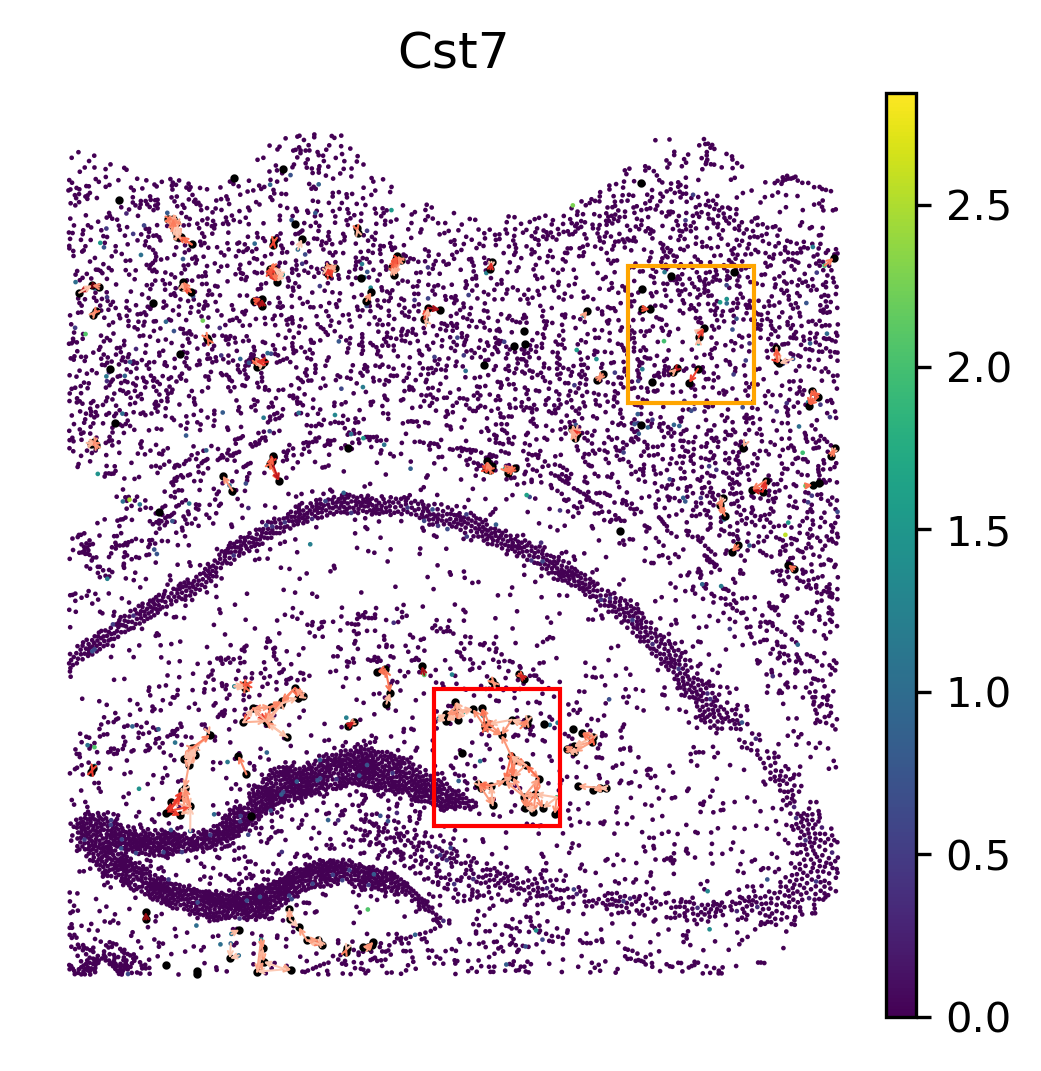

In [ ]:
expression_list = []
attribution_list = []

fig, ax = plt.subplots(1, figsize=(4, 4), dpi=300)

ax.set_axis_off()
ax.set_frame_on(False)

sc.pl.embedding(adata, basis='spatial', color=target, ax=ax, show=False, s=5)

for i, source_index in enumerate(abeta_positive_index):
    neighbors = dataset.graph[source_index]

    for j, target_index in enumerate(neighbors):
        x1, y1 = adata[source_index].obsm['spatial'][0]
        x2, y2 = adata[target_index].obsm['spatial'][0]

        # score_dic[adata[target_index].obs['ct_sub'].values[0]].append(selected_attributions_[i, j])
        expression_list.append(adata[target_index, target].X.item())
        attribution_list.append(selected_attributions_[i, j].item())

        if selected_attributions_[i, j] > 0.2:
            ax.annotate('',                              
                        xy=(x1, y1), 
                        xytext=(x2, y2),
                        arrowprops=dict(
                            arrowstyle='->', 
                            color=color[i,j],
                            lw=.5,
                            shrinkA=0, shrinkB=0,
                            mutation_scale=3, 
                            # alpha=0.1 
                        )
                    )

ax.scatter(adata.obsm['spatial'][outputs_list, 0], adata.obsm['spatial'][outputs_list, 1], color='black', s=1)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()


rect = patches.Rectangle(
    (3200, 1200), 
    1100,           
    1100,            
    linewidth=1., 
    edgecolor='red', 
    facecolor='none'
)
ax.add_patch(rect)

rect = patches.Rectangle(
    (4900, 4600), 
    1100,           
    1100,            
    linewidth=1., 
    edgecolor='orange', 
    facecolor='none'
)
ax.add_patch(rect)

Pearson correlation coefficient (PCC): 0.9472, p-value: 0.0000
Spearman correlation coefficient (SPCC): 0.9973, p-value: 0.0000


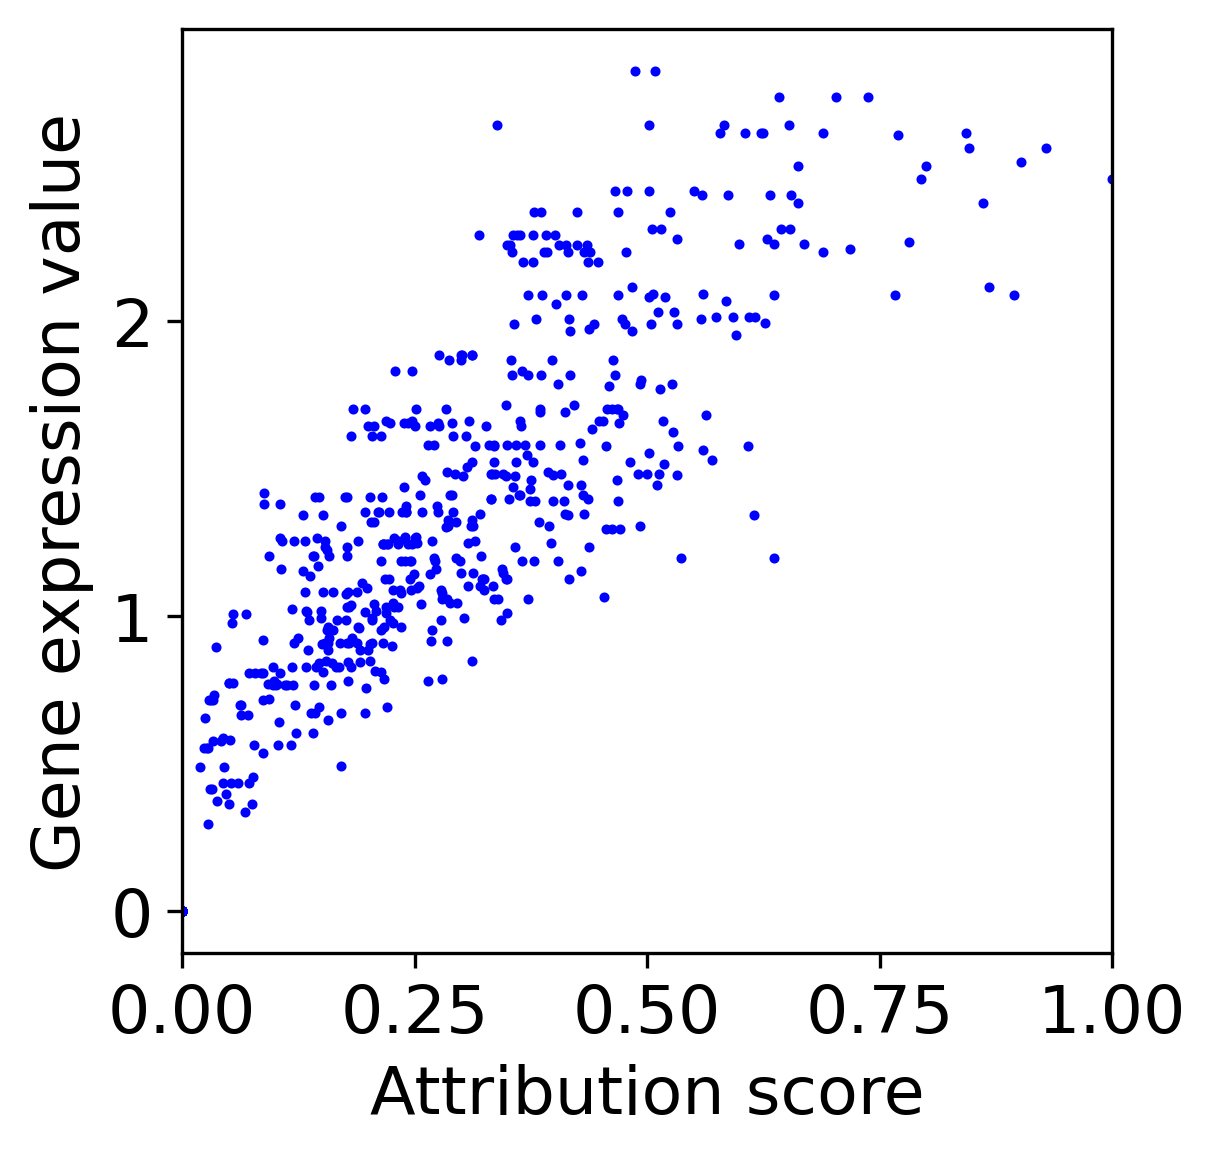

In [33]:
from scipy.stats import pearsonr, spearmanr
pcc, p_value_pcc = pearsonr(attribution_list, expression_list)
spcc, p_value_spcc = spearmanr(attribution_list, expression_list)

print(f"Pearson correlation coefficient (PCC): {pcc:.4f}, p-value: {p_value_pcc:.4f}")
print(f"Spearman correlation coefficient (SPCC): {spcc:.4f}, p-value: {p_value_spcc:.4f}")

fig, ax = plt.subplots(figsize=(4,4), dpi=300)

ax.scatter(attribution_list, expression_list, color='blue', marker='o', s=2)  # 你也可以改颜色或点的形状

# plt.title("散点图示例", fontsize=14)
ax.set_xlabel("Attribution score", fontsize=16)
ax.set_ylabel("Gene expression value", fontsize=16)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=16)

plt.show()

This part is for visualizing the interactions within niches. 

In [34]:
# import matplotlib.patches as mpatches

# save_dir = f'./niche_level_{target}_attribution/'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# for index, source_index in enumerate(abeta_positive_index):

#     fig, ax1 = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)
    
#     source_index = abeta_positive_index[index]
#     neighbors = dataset.graph[source_index]
#     sc.pl.embedding(adata[[source_index] + neighbors], basis='spatial', color=target, ax=ax1, show=False, s=25, colorbar_loc=None, vmax=adata[:, target].X.max())

#     # labels = adata[[source_index] + neighbors].obs[target].values

#     for j, target_index in enumerate(neighbors):

#         x1, y1 = adata[source_index].obsm['spatial'][0]
#         x2, y2 = adata[target_index].obsm['spatial'][0]

#         ax1.annotate('',                            
#                     xy=(x1, y1), 
#                     xytext=(x2, y2), 
#                     arrowprops=dict(
#                         arrowstyle='->', 
#                         color=color[index ,j], 
#                         lw=.8, 
#                         shrinkA=0, shrinkB=4, 
#                         mutation_scale=4, 
#                         # alpha=0.1
#                     ),
#                     zorder=0
#                 )

#     ax1.scatter(x1, y1, facecolors='none', edgecolors='grey', s=50, linewidths=0.5)
#     ax1.set_title(source_index)

#     ax1.set_axis_off()
#     ax1.set_frame_on(False)
#     plt.title('')
#     plt.savefig(save_dir + f"{source_index}.png", dpi=300, bbox_inches='tight')
#     plt.close()

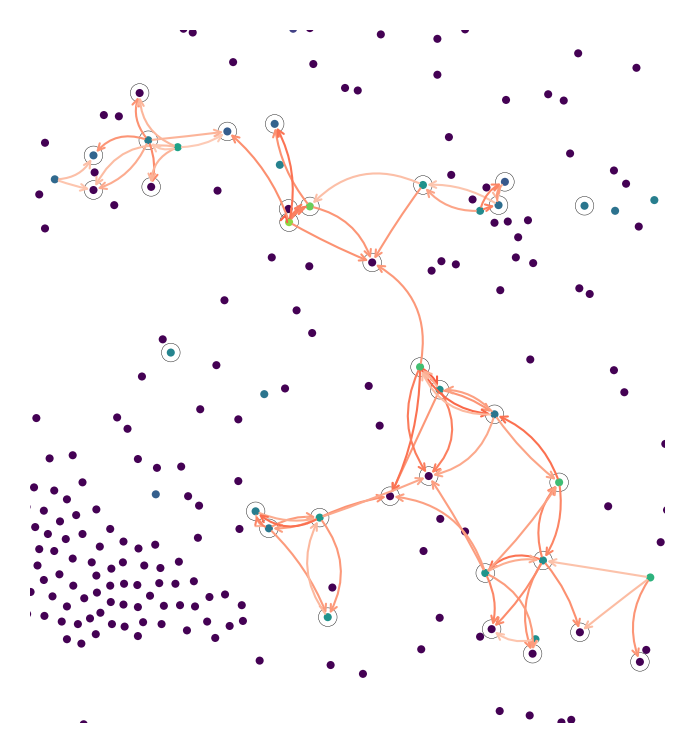

In [35]:
fig, ax = plt.subplots(1, figsize=(3, 3), dpi=300)
sc.pl.embedding(adata, basis='spatial', color=target, ax=ax, show=False, s=15, legend_loc=None)

ax.set_axis_off()
ax.set_frame_on(False)

for i, source_index in enumerate(abeta_positive_index):
    neighbors = dataset.graph[source_index]

    for j, target_index in enumerate(neighbors):

        x1, y1 = adata[source_index].obsm['spatial'][0]
        x2, y2 = adata[target_index].obsm['spatial'][0]

        if selected_attributions_[i, j] > 0.2:
            ax.annotate('',
                        xy=(x1, y1), 
                        xytext=(x2, y2),
                        arrowprops=dict(
                            arrowstyle='->', 
                            color=color[i,j],
                            lw=0.5,
                            shrinkA=1, shrinkB=1,
                            mutation_scale=4,
                            # alpha=0.5, 
                            connectionstyle=f"arc3,rad={np.random.uniform(-0.4, 0.4)}"
                        )
                    )

ax.scatter(adata.obsm['spatial'][outputs_list, 0], adata.obsm['spatial'][outputs_list, 1], facecolors='none', edgecolors='black', s=20, linewidths=0.1)

# ax.set_xlim(1260, 2100)
# ax.set_ylim(1500, 2500)
ax.set_xlim(3200, 4300)
ax.set_ylim(1200, 2300)
ax.set_title('')

if ax.get_figure().axes[-1] != ax:
    ax.get_figure().axes[-1].remove()

plt.show()

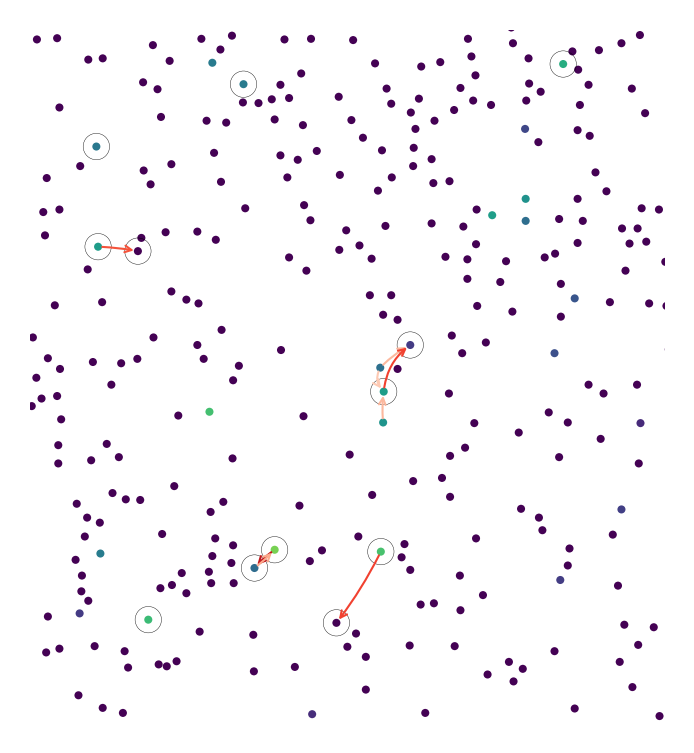

In [36]:
fig, ax = plt.subplots(1, figsize=(3, 3), dpi=300)
sc.pl.embedding(adata, basis='spatial', color=target, ax=ax, show=False, s=15, legend_loc=None)

ax.set_axis_off()
ax.set_frame_on(False)

for i, source_index in enumerate(abeta_positive_index):
    neighbors = dataset.graph[source_index]

    for j, target_index in enumerate(neighbors):

        x1, y1 = adata[source_index].obsm['spatial'][0]
        x2, y2 = adata[target_index].obsm['spatial'][0]

        if selected_attributions_[i, j] > 0.2:
            ax.annotate('',
                        xy=(x1, y1), 
                        xytext=(x2, y2),
                        arrowprops=dict(
                            arrowstyle='->', 
                            color=color[i,j],
                            lw=0.5,
                            shrinkA=1, shrinkB=1,
                            mutation_scale=4,
                            # alpha=0.5, 
                            connectionstyle=f"arc3,rad={np.random.uniform(-0.4, 0.4)}"
                        )
                    )

ax.scatter(adata.obsm['spatial'][outputs_list, 0], adata.obsm['spatial'][outputs_list, 1], facecolors='none', edgecolors='black', s=40, linewidths=0.1)

ax.set_xlim(4900, 6000)
ax.set_ylim(4600, 5700)
ax.set_title('')

if ax.get_figure().axes[-1] != ax:
    ax.get_figure().axes[-1].remove()

plt.show()